In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model 
from keras.utils import np_utils 
import cv2
import glob
import numpy as np

/Users/norikaisa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X = []
files = glob.glob ("/Users/norikaisa/Downloads/Book/unnoisy train/normal/*.png")
for myFile in files:
    image = cv2.imread (myFile)
    X.append (image)
print('X shape:', np.array(X).shape)

files = glob.glob ("/Users/norikaisa/Downloads/Book/unnoisy train/abnormal/*.png")
for myFile in files:
    image = cv2.imread (myFile)
    X.append (image)
print('X shape:', np.array(X).shape)

X shape: (3280, 30, 50, 3)
X shape: (5532, 30, 50, 3)


In [3]:
X_validation = []
files = glob.glob ("/Users/norikaisa/Downloads/Book/unnoisy test/normal/*.png")
for myFile in files:
    image = cv2.imread (myFile)
    X_validation.append (image)
print('X_validation shape:', np.array(X_validation).shape)

files = glob.glob ("/Users/norikaisa/Downloads/Book/unnoisy test/abnormal/*.png")
for myFile in files:
    image = cv2.imread (myFile)
    X_validation.append (image)
print('X_validation shape:', np.array(X_validation).shape)

X_validation shape: (409, 30, 50, 3)
X_validation shape: (690, 30, 50, 3)


In [4]:
X = np.array(X).astype('float32') / 255.
X = X.reshape((len(X), np.prod(X.shape[1:])))
X_validation = np.array(X_validation).astype('float32') / 255.
X_validation = X_validation.reshape((len(X_validation), np.prod(X_validation.shape[1:])))

In [5]:
original_dim = 30*50*3
latent_dim = 2
intermediate_dim = 256

In [6]:
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from scipy.stats import norm

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), 
                              mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [7]:
# instantiate VAE model
vae = Model(x, x_decoded_mean)

encoder = Model(x, z_mean)

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [8]:
from keras import metrics
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop', loss = '')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4500)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1152256     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/Users/norikaisa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.
  


In [9]:
vae.fit(X,
        shuffle=True,
        epochs=50,
        batch_size=275,
        validation_data=(X_validation, None))

Train on 5532 samples, validate on 690 samples
Epoch 1/50
5532/5532 [==============================] - 3s 532us/step - loss: 1694.0989 - val_loss: 1315.1465
Epoch 2/50
5532/5532 [==============================] - 2s 442us/step - loss: 1290.3699 - val_loss: 1242.4799
Epoch 3/50
5532/5532 [==============================] - 2s 442us/step - loss: 1262.7779 - val_loss: 1265.8100
Epoch 4/50
5532/5532 [==============================] - 2s 440us/step - loss: 1251.3224 - val_loss: 1241.2800
Epoch 5/50
5532/5532 [==============================] - ETA: 0s - loss: 1245.67 - 3s 491us/step - loss: 1245.7620 - val_loss: 1267.9968
Epoch 6/50
5532/5532 [==============================] - 3s 462us/step - loss: 1240.6752 - val_loss: 1218.8504
Epoch 7/50
5532/5532 [==============================] - 3s 500us/step - loss: 1232.1910 - val_loss: 1241.9429
Epoch 8/50
5532/5532 [==============================] - 2s 441us/step - loss: 1238.3950 - val_loss: 1211.5556
Epoch 9/50
5532/5532 [=========================

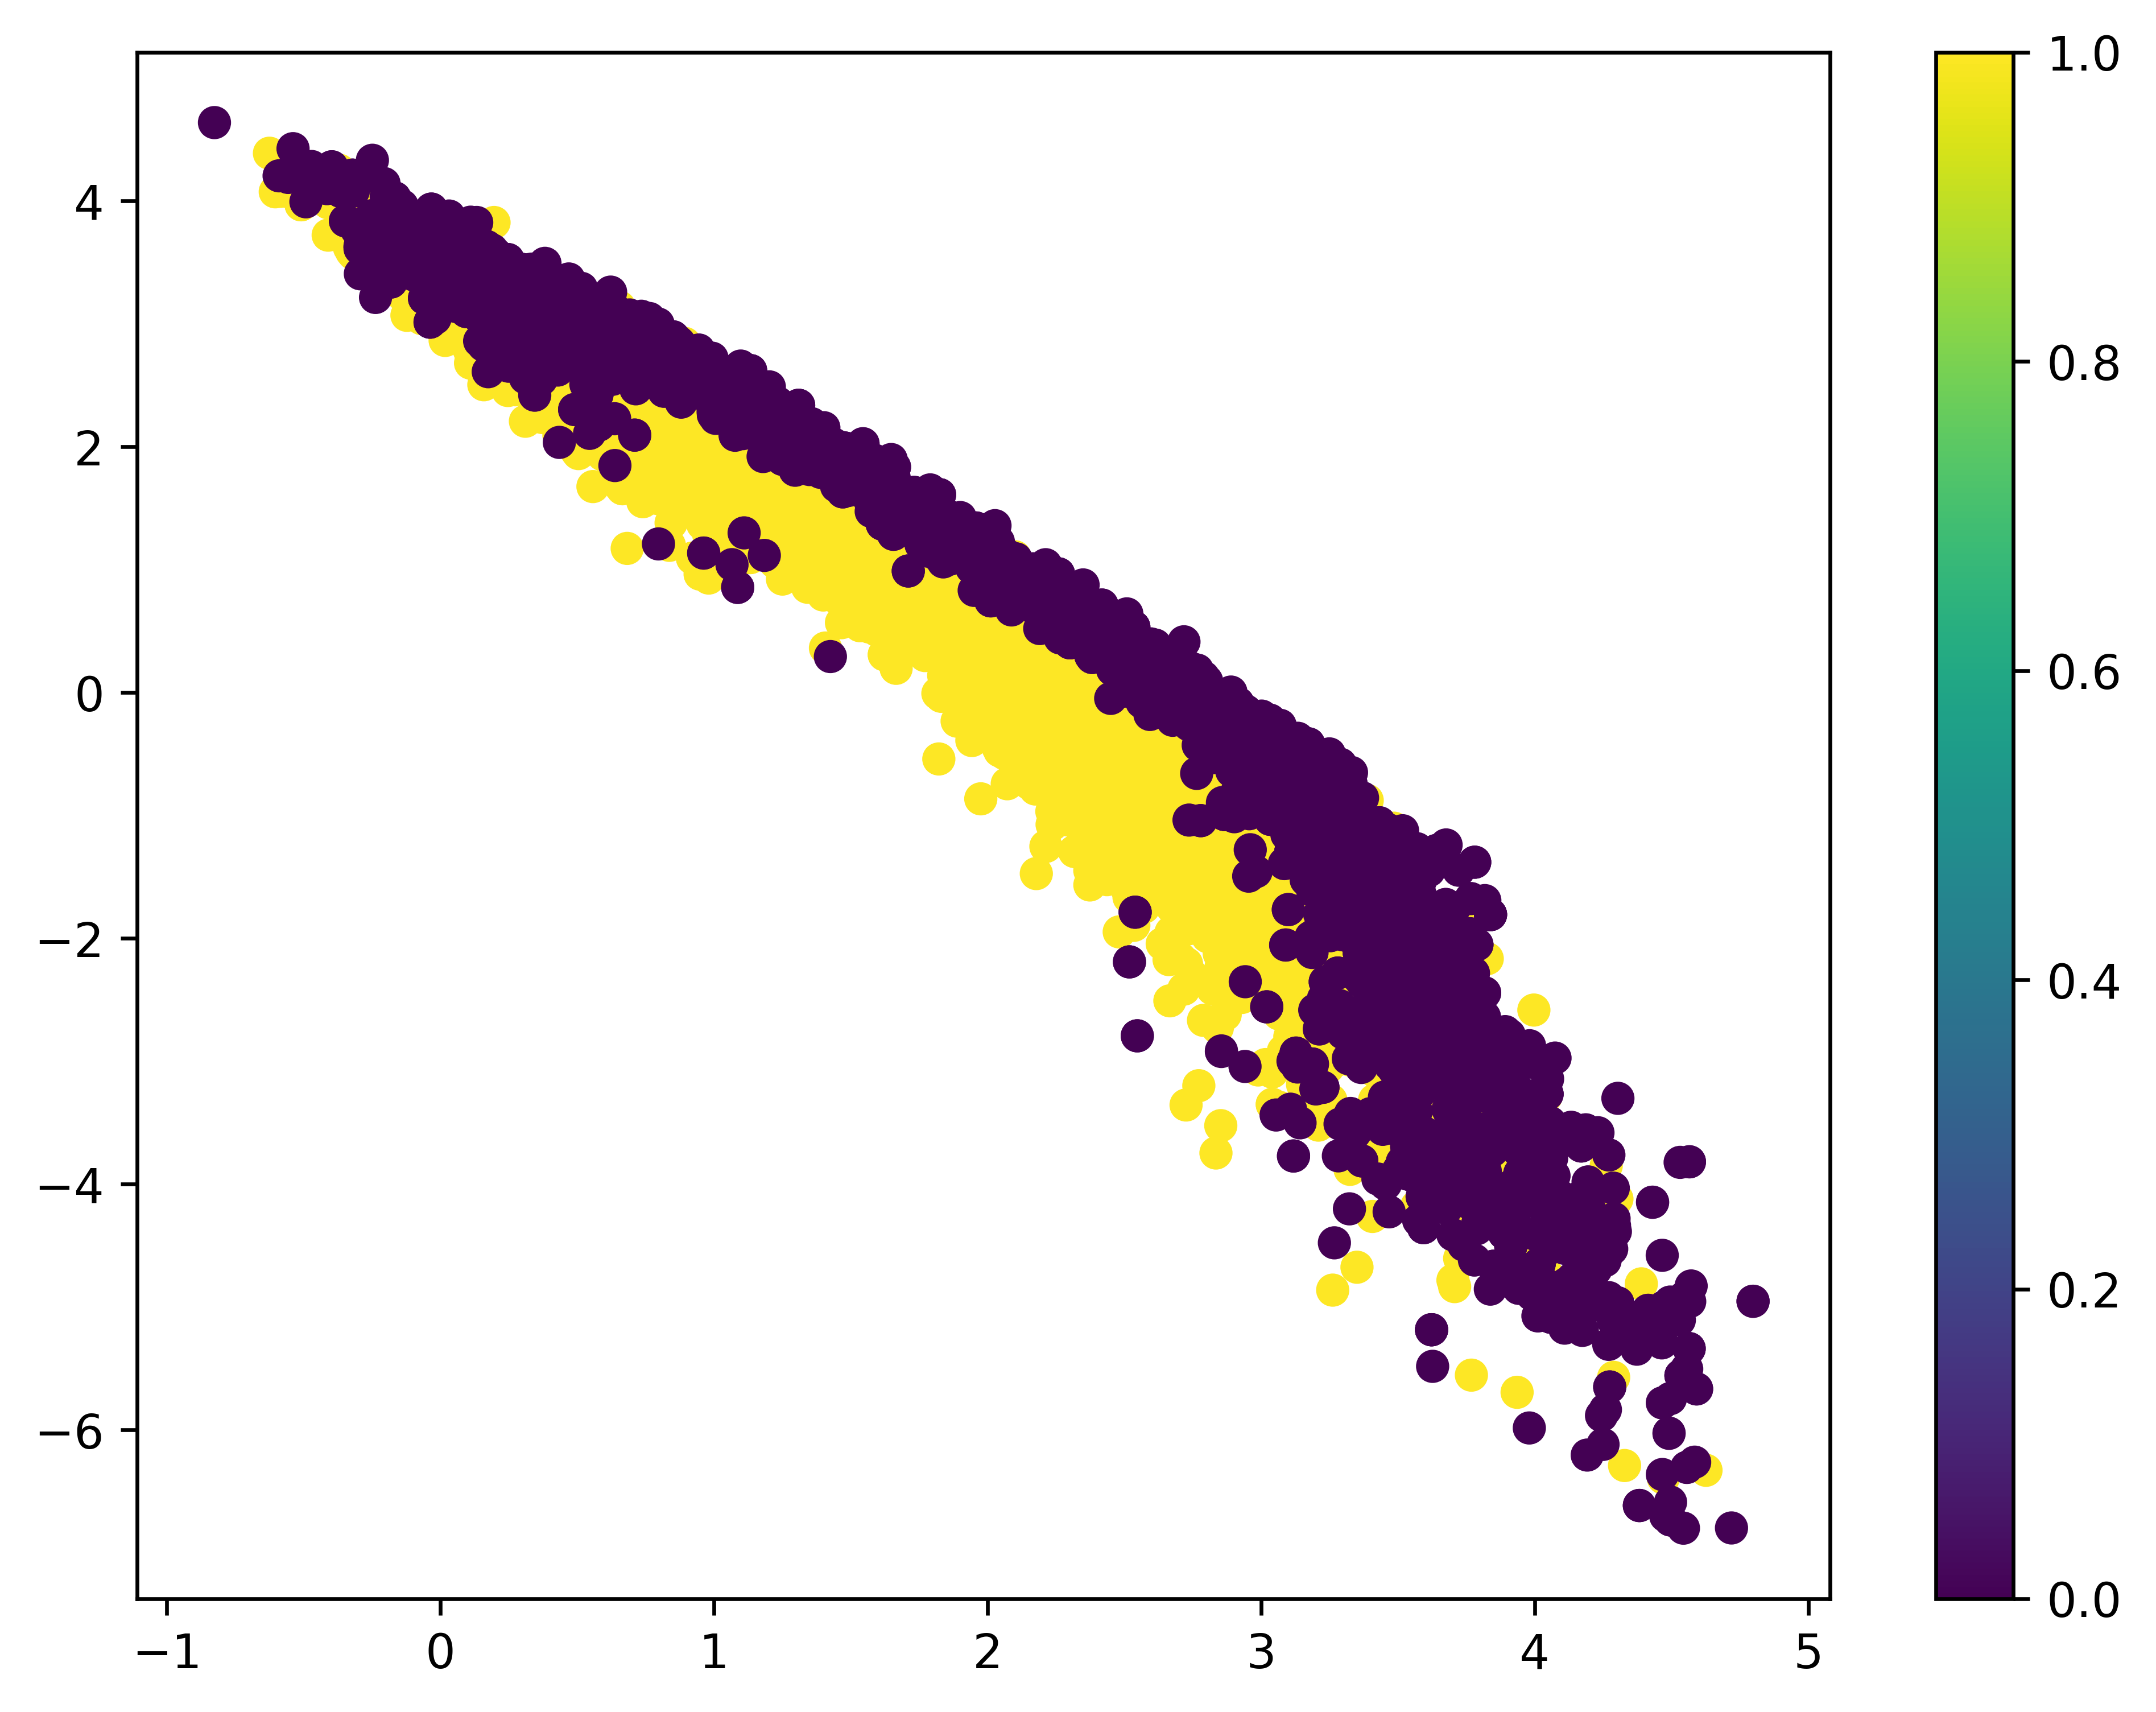

In [11]:
import matplotlib.pyplot as plt

Y = np.zeros((5532,), dtype=np.uint8)
Y[0:3280] = 1

X_noisy_encoded = encoder.predict(X, batch_size=275)
plt.figure(figsize=(8,6), dpi = 600)
plt.scatter(X_noisy_encoded[:, 0], X_noisy_encoded[:, 1], c=Y)
plt.colorbar()
plt.show()